In [1]:
import sys
import re, numpy as np, pandas as pd

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
import string

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [2]:
#Define stopwords
punctuation = "".join([symbol for symbol in string.punctuation if symbol not in ["'", '"']])
punctuation += '–'
punctuation += '...'

stopwords_list = stopwords.words('english')
stopwords_list += list(punctuation)

In [3]:
#Checking my list of stopwords
stopwords_list

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

# Getting DF

In [71]:
#Importing dataframes
df = pd.read_pickle('script_TM')

In [72]:
df.shape

(1086, 2)

In [73]:
df.head(25)

,Speaker,Text
0,COMPUTER SCREEN,So close it has no boundaries. A blinking cur...
1,MAN (V.O.),"Hello? Data now slashes across the screen, ..."
2,SCREEN,Call trans opt: received. 2-19-96 13:24...
3,WOMAN (V.O.),I'm inside. Anything to report? We listen ...
4,TRINITY.,
5,CYPHER (V.O.),Let's see. Target left work at
6,5:01 PM.,
7,SCREEN,Trace program: running. The entire screen ...
8,CYPHER (V.O.),He caught the northbound Howard line. Go...
9,TRINITY (V.O.),"All right, you're relieved. Use the usua..."


# Cleaning DF

In [74]:
df.Speaker.value_counts()

     NEO                                   175
     MORPHEUS                              134
     TRINITY                               120
     AGENT SMITH                            73
     TANK                                   60
                                          ... 
 INT.  WASTE LINE                            1
 INT.  NEO'S CUBICLE                         1
 INT.  ORACLE'S CHAMBERS (MATRIX) - DAY      1
     RADIO (V.O.)                            1
 EXT.  FIRE E5CAPE                           1
Name: Speaker, Length: 156, dtype: int64

In [75]:
df.Speaker.nunique()

156

In [76]:
df.Speaker.unique()

array([' COMPUTER SCREEN', '     MAN (V.O.)', '     SCREEN',
       '     WOMAN (V.O.)', ' TRINITY.', '     CYPHER (V.O.)',
       '   5:01 PM.', '     TRINITY (V.O.)', '     TRINITY',
       '   #312-555-0690', '     CYPHER (V.O.) ', '     RADIO (V.O.)',
       ' INT.  CHASE HOTEL - NIGHT', '     BIG COP',
       ' EXT.  CHASE HOTEL - NIGHT', '     AGENT SMITH',
       '     LIEUTENANT', '     AGENT SMITH ', ' INT.  CHASE HOTEL',
       ' FIRES --', ' EXT.  CHASE HOTEL', '     MORPHEUS (V.O.)',
       ' INT.  HALL', ' EXT.  FIRE E5CAPE', ' EXT.  ROOF', '     COP',
       ' EXT.  STREET', '     AGENT JONES', '   FOS4:  ALL HAIL SEGA!!!',
       " INT.  NEO'S APARTMENT", '     NEO', '     VOICE (O.S.)',
       '     ANTHONY', '     DUJOUR', ' INT.  APARTMENT',
       '       CUT TO:', ' 9:15 A.M.', ' EXT.  SKYSCRAPER',
       ' INT.  CORTECHS OFFICE', '     RHINEHEART',
       " INT.  NEO'S CUBICLE", '     TALL EMPLOYEE', '     FEDEX',
       ' INT.  INTERROGATION ROOM - CLOSE ON CAMERA

* I need to remove all the V.O to keep only the names 

In [77]:
#create a function that take a text and remove the "V.O" at the end

def remove_vo(text):
    
    #check the length of the split and evaluate the second part to VO
    if len(text.split()) == 2:
        if text.split()[1] in ['(V.O.)','(V.O.).']:
            return text.split()[0]
        else: 
            return text
    else:
        return text

In [78]:
#Use split to take the V.O at the end of the in the Speaker name
df.Speaker = df.Speaker.apply(lambda x: remove_vo(x))

In [79]:
print(df.shape)
df.tail(25)

(1086, 2)


,Speaker,Text
1061,INT. HOTEL HALL (MATRIX) - DAY,The BLOW ECHOES deep in his mind. His eyes sn...
1062,INT. HOVERCRAFT,Trinity screams as the monitors jump back to ...
1063,TRINITY,Now get up!
1064,INT. HALL (MATRIX) - DAY,"Neo struggles, holding his chest, sitting up...."
1065,AGENT SMITH,Nooooo! Agent Smith pounds on the elevator ...
1066,INT. HOVERCRAFT,A sentinel BLOWS a hole in Morpheus' right ar...
1067,INT. ROOM 303 (MATRIX) - DAY,Neo dives for the RINGING PHONE.
1068,INT. HOVERCRAFT,"Machines split open the craft, pouring in, la..."
1069,TRINITY,Now! He turns the key.
1070,INT. OVERFLOW PIT,A blinding shock of white lights flood the ch...


In [80]:
df.head(25)

,Speaker,Text
0,COMPUTER SCREEN,So close it has no boundaries. A blinking cur...
1,MAN,"Hello? Data now slashes across the screen, ..."
2,SCREEN,Call trans opt: received. 2-19-96 13:24...
3,WOMAN,I'm inside. Anything to report? We listen ...
4,TRINITY.,
5,CYPHER,Let's see. Target left work at
6,5:01 PM.,
7,SCREEN,Trace program: running. The entire screen ...
8,CYPHER,He caught the northbound Howard line. Go...
9,TRINITY,"All right, you're relieved. Use the usua..."


In [81]:
sorted(list(df.Speaker.unique()))

['          FADE OUT.',
 '         FADE TO BLACK.',
 '       CUT TO:',
 '     AGENT BROWN',
 '     AGENT BROWTJ',
 '     AGENT JONES',
 '     AGENT SMITH',
 '     AGENT SMITH ',
 '     ANTHONY',
 '     APOC',
 '     BIG COP',
 '     BOY',
 '     CABLE',
 '     COP',
 '     COPS',
 '     CYPHER',
 '     CYPHER,',
 '     DOZER',
 '     DUJOUR',
 '     FEDEX',
 '     GIZMO',
 '     LIEUTENANT',
 '     MAN (O.S.)',
 '     MOJO',
 '     MOMMY',
 '     MORPHEUS',
 '     MOUSE',
 '     NEO',
 '     OLD MAN',
 '     ORACLE',
 '     ORACLE (WOMAN)',
 '     PILOT',
 '     PRIESTESS',
 '     REX',
 '     RHINEHEART',
 '     SCREEN',
 '     SERGEANT',
 '     SPOON BOY',
 '     SWITCH',
 '     TALL EMPLOYEE',
 '     TANK',
 '     THE END',
 '     TRINITY',
 '     VOICE (O.S.)',
 '     WOMAN (O.S.)',
 '    MORPHEUS',
 '   #312-555-0690',
 '   5:01 PM.',
 '   E.M.P?',
 '   FOS4:  ALL HAIL SEGA!!!',
 '   R.S.I.',
 ' --',
 ' 305...  304...',
 ' 9:15 A.M.',
 ' A."',
 ' ANGLE ON NEO',
 ' BA-BOOM!',
 ' BO

In [82]:
len(df.Speaker.unique())

154

In [83]:
len(df.loc[df['Speaker'] == '     NEO'])

175

I need to delete extra space in speaker name

In [84]:
#create a function to remove space before the name
def remove_space(text):
    return " ".join(text.split())

In [85]:
#Use the function to remove extra space
df.Speaker = df.Speaker.apply(lambda x: remove_space(x))

In [86]:
len(df.Speaker.unique())

146

In [87]:
df.Speaker.value_counts()

NEO                           180
MORPHEUS                      166
TRINITY                       132
AGENT SMITH                    74
TANK                           69
                             ... 
INT. WASTE LINE                 1
INT. STAIRS (MATRIX) - DAY      1
REX                             1
CLICK.                          1
E.M.P?                          1
Name: Speaker, Length: 146, dtype: int64

In [88]:
df.loc[df['Speaker'] == 'NEO'].head()

,Speaker,Text
66,NEO,Fuckin' idiots don't know shit. He finishes...
69,NEO,What the hell...
72,NEO,"What do you want, Anthony?"
74,NEO,You got the money this time? He holds up tw...
82,NEO,I don't know. I have to work tomorrow.


I need to delete all the cells without text --> len(text) == 0

In [89]:
#work with the cells without text

In [65]:
#Check if it is None or blank
# df.Text.iloc[4] == None #False
df.Text.iloc[4] == '' #True

True

In [90]:
#How many of these empty cells do I have?
len(df[df.Text == ''])

20

In [91]:
df.head()

,Speaker,Text
0,COMPUTER SCREEN,So close it has no boundaries. A blinking cur...
1,MAN,"Hello? Data now slashes across the screen, ..."
2,SCREEN,Call trans opt: received. 2-19-96 13:24...
3,WOMAN,I'm inside. Anything to report? We listen ...
4,TRINITY.,


In [168]:
df_cleaned = df[df.Text != ''].reset_index(drop=True)

In [169]:
df_cleaned.head()

,Speaker,Text
0,COMPUTER SCREEN,So close it has no boundaries. A blinking cursor pulses in the electric darkness like a heart c...
1,MAN,"Hello? Data now slashes across the screen, information flashing faster than we read."
2,SCREEN,Call trans opt: received. 2-19-96 13:24:18 REC:Log>
3,WOMAN,I'm inside. Anything to report? We listen to the phone conversation as though we were on a t...
4,CYPHER,Let's see. Target left work at


In [170]:
df_cleaned.shape

(1066, 2)

In [171]:
df_cleaned.Speaker.value_counts()

NEO                               180
MORPHEUS                          166
TRINITY                           132
AGENT SMITH                        74
TANK                               69
                                 ... 
EXT. FIRE E5CAPE                    1
AGENT BROWTJ                        1
INT. NIKO HOTEL (MATRIX) - DAY      1
INT. NEO'S APARTMENT - NIGHT        1
INT. STAIRS (MATRIX) - DAY          1
Name: Speaker, Length: 132, dtype: int64

In [172]:
#Saving as pickle
import pickle 
with open('script_cleaned_TM.pkl', 'wb') as f:
            pickle.dump(df_cleaned, f)

In [ ]:
#transform into words -- done
#removing words stops -- not sure
#counts words -- done
#counts words per actor -- not yet
#graphs
#topic modeling

# Tokenize

In [131]:
#Function to convert sentences to words
#removing stopwords
def sent_to_words(sentences):
    for sent in sentences:
#         sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\t', ' ', sent)  # remove newline chars
        sent = re.sub('\n', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        #removing stopwords
        sent = 
#         yield(sent) 
    return sent

In [173]:
df_cleaned['Words'] = df_cleaned.Text.apply(lambda x: sent_to_words([x]))

In [174]:
df_cleaned.head()

,Speaker,Text,Words
0,COMPUTER SCREEN,So close it has no boundaries. A blinking cursor pulses in the electric darkness like a heart c...,"[so, close, it, has, no, boundaries, blinking, cursor, pulses, in, the, electric, darkness, like..."
1,MAN,"Hello? Data now slashes across the screen, information flashing faster than we read.","[hello, data, now, slashes, across, the, screen, information, flashing, faster, than, we, read]"
2,SCREEN,Call trans opt: received. 2-19-96 13:24:18 REC:Log>,"[call, trans, opt, received, rec, log]"
3,WOMAN,I'm inside. Anything to report? We listen to the phone conversation as though we were on a t...,"[im, inside, anything, to, report, we, listen, to, the, phone, conversation, as, though, we, wer..."
4,CYPHER,Let's see. Target left work at,"[lets, see, target, left, work, at]"


In [112]:
# Convert to list
# data = df_cleaned.Text.values.tolist()
# data_words = list(sent_to_words(data))
# print(data_words[:1])

[['so', 'close', 'it', 'has', 'no', 'boundaries', 'blinking', 'cursor', 'pulses', 'in', 'the', 'electric', 'darkness', 'like', 'heart', 'coursing', 'with', 'phosphorous', 'light', 'burning', 'beneath', 'the', 'derma', 'of', 'black', 'neon', 'glass', 'phone', 'begins', 'to', 'ring', 'we', 'hear', 'it', 'as', 'though', 'we', 'were', 'making', 'the', 'call', 'the', 'cursor', 'continues', 'to', 'throb', 'relentlessly', 'patient', 'until']]


In [175]:
df_cleaned.Words[0]

['so',
 'close',
 'it',
 'has',
 'no',
 'boundaries',
 'blinking',
 'cursor',
 'pulses',
 'in',
 'the',
 'electric',
 'darkness',
 'like',
 'heart',
 'coursing',
 'with',
 'phosphorous',
 'light',
 'burning',
 'beneath',
 'the',
 'derma',
 'of',
 'black',
 'neon',
 'glass',
 'phone',
 'begins',
 'to',
 'ring',
 'we',
 'hear',
 'it',
 'as',
 'though',
 'we',
 'were',
 'making',
 'the',
 'call',
 'the',
 'cursor',
 'continues',
 'to',
 'throb',
 'relentlessly',
 'patient',
 'until']

In [176]:
df_cleaned['No_Words'] = df_cleaned.Words.apply(lambda x: len(x))

In [177]:
df_cleaned.head()

,Speaker,Text,Words,No_Words
0,COMPUTER SCREEN,So close it has no boundaries. A blinking cursor pulses in the electric darkness like a heart c...,"[so, close, it, has, no, boundaries, blinking, cursor, pulses, in, the, electric, darkness, like...",49
1,MAN,"Hello? Data now slashes across the screen, information flashing faster than we read.","[hello, data, now, slashes, across, the, screen, information, flashing, faster, than, we, read]",13
2,SCREEN,Call trans opt: received. 2-19-96 13:24:18 REC:Log>,"[call, trans, opt, received, rec, log]",6
3,WOMAN,I'm inside. Anything to report? We listen to the phone conversation as though we were on a t...,"[im, inside, anything, to, report, we, listen, to, the, phone, conversation, as, though, we, wer...",25
4,CYPHER,Let's see. Target left work at,"[lets, see, target, left, work, at]",6


In [183]:
df_cleaned.groupby(['Speaker']).sum()

,No_Words
Speaker,
--,76
305... 304...,30
AGENT BROWN,44
AGENT BROWTJ,3
AGENT JONES,204
AGENT SMITH,1664
ANGLE ON NEO,26
ANTHONY,87
APOC,171


In [128]:
len(data)

1066

# Build Bigram, Trigram Models and Lemmatize

In [113]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once

In [114]:
def process_words(texts, stop_words=stopwords_list, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

In [115]:
data_ready = process_words(data_words)  # processed the entire movie

In [116]:
data_ready[:1]

[['close',
  'boundary',
  'blink',
  'cursor',
  'pulse',
  'electric',
  'darkness',
  'heart',
  'course',
  'phosphorous',
  'light',
  'burn',
  'black',
  'neon',
  'glass',
  'phone',
  'begin',
  'ring',
  'hear',
  'make',
  'call',
  'continue',
  'relentlessly',
  'patient']]

# Build the Topic Modeling

In [117]:
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

In [118]:
#check the topic
for topic in lda_model.print_topics():
    print(topic)
    print("--------")
# print(lda_model.print_topics())

(0, '0.057*"trinity" + 0.041*"open" + 0.028*"stare" + 0.022*"door" + 0.021*"turn" + 0.021*"car" + 0.019*"elevator" + 0.018*"find" + 0.018*"bullet" + 0.018*"fire"')
--------
(1, '0.056*"tank" + 0.033*"start" + 0.029*"still" + 0.029*"try" + 0.024*"little" + 0.024*"boy" + 0.024*"pull" + 0.023*"believe" + 0.019*"even" + 0.019*"drive"')
--------
(2, '0.054*"see" + 0.051*"go" + 0.048*"know" + 0.040*"get" + 0.031*"begin" + 0.028*"black" + 0.026*"let" + 0.024*"glass" + 0.016*"work" + 0.015*"move"')
--------
(3, '0.031*"look" + 0.030*"hole" + 0.027*"hold" + 0.027*"man" + 0.026*"gun" + 0.026*"fall" + 0.025*"body" + 0.023*"scream" + 0.021*"eye" + 0.019*"neo"')
--------
(4, '0.073*"phone" + 0.033*"hear" + 0.028*"ring" + 0.021*"make" + 0.021*"take" + 0.021*"agent_jone" + 0.020*"close" + 0.018*"right" + 0.017*"drop" + 0.016*"window"')
--------
(5, '0.039*"agent" + 0.036*"fly" + 0.025*"stand" + 0.024*"back" + 0.019*"air" + 0.018*"metal" + 0.017*"shoot" + 0.016*"blow" + 0.016*"coat" + 0.015*"walk"')
-

# Dominant topic and its percentage contribution in each text/action

In [119]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [120]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

In [121]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.5378,"phone, hear, ring, make, take, agent_jone, clo...","[close, boundary, blink, cursor, pulse, electr..."
1,1,5.0,0.8752,"agent, fly, stand, back, air, metal, shoot, bl...","[slash, screen, information, flash, faster, read]"
2,2,4.0,0.7785,"phone, hear, ring, make, take, agent_jone, clo...","[call, receive, log]"
3,3,4.0,0.3555,"phone, hear, ring, make, take, agent_jone, clo...","[report, listen, phone, conversation, third, l..."
4,4,2.0,0.5507,"see, go, know, get, begin, black, let, glass, ...","[let, see, target, leave, work]"
5,5,5.0,0.5232,"agent, fly, stand, back, air, metal, shoot, bl...","[program, run, entire, screen, fill, race, col..."
6,6,2.0,0.5187,"see, go, know, get, begin, black, let, glass, ...","[catch, line, get, stop, purchase, pack, retur..."
7,7,4.0,0.8545,"phone, hear, ring, make, take, agent_jone, clo...","[right, relieved, use, usual, exit]"
8,8,2.0,0.5771,"see, go, know, get, begin, black, let, glass, ...","[know, go, make, contact]"
9,9,3.0,0.5380,"look, hole, hold, man, gun, fall, body, scream...","[soon, thin, digit, leave]"


In [122]:
#Let's have a look
df_dominant_topic.shape

(1066, 5)

In [123]:
df_dominant_topic.Dominant_Topic.value_counts(normalize=True)

0.0    0.268293
2.0    0.177298
3.0    0.160413
1.0    0.144465
4.0    0.144465
5.0    0.105066
Name: Dominant_Topic, dtype: float64

In [125]:
df_cleaned.shape

(1066, 2)

# Most representative action for each topic

In [126]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.8809,"trinity, open, stare, door, turn, car, elevator, find, bullet, fire","[hand, head, slowly, put, hand, head]"
1,1.0,0.8297,"tank, start, still, try, little, boy, pull, believe, even, drive","[like, idea, control, life]"
2,2.0,0.8798,"see, go, know, get, begin, black, let, glass, work, move","[finish, operation, program, show, great, retention]"
3,3.0,0.8445,"look, hole, hold, man, gun, fall, body, scream, eye, neo","[protection, seal, eye, shut, tape]"
4,4.0,0.9128,"phone, hear, ring, make, take, agent_jone, close, right, drop, window","[muscle, atrophy, rebuild, fluorescent, light, stick, burn, unnaturally, bright]"
5,5.0,0.8958,"agent, fly, stand, back, air, metal, shoot, blow, coat, walk","[water, foot, diameter, pipe, feed, sewer, main]"


# Frequency Distribution of Word Counts in movie

0 [('trinity', 0.057005573), ('open', 0.04077079), ('stare', 0.027575022), ('door', 0.022233), ('turn', 0.021212297), ('car', 0.02085), ('elevator', 0.018781463), ('find', 0.01815649), ('bullet', 0.018015673), ('fire', 0.017999848), ('smile', 0.016178189), ('throw', 0.013214424), ('hang', 0.013004435), ('dark', 0.012971193), ('ear', 0.01205986), ('agent_smith', 0.011592167), ('hand', 0.011226714), ('sit', 0.010790948), ('explode', 0.00980296), ('almost', 0.009300638), ('shake', 0.008923111), ('room', 0.008709643), ('piece', 0.008674875), ('monitor', 0.008523919), ('rope', 0.00822046), ('head', 0.007752829), ('slow', 0.007697315), ('blast', 0.0074375747), ('wear', 0.007329866), ('finger', 0.007242171)]
1 [('tank', 0.055619054), ('start', 0.032647736), ('still', 0.029183129), ('try', 0.028952075), ('little', 0.024478754), ('boy', 0.023943635), ('pull', 0.023509664), ('believe', 0.023329122), ('even', 0.019392084), ('drive', 0.019282544), ('life', 0.018820642), ('think', 0.014958112), ('l

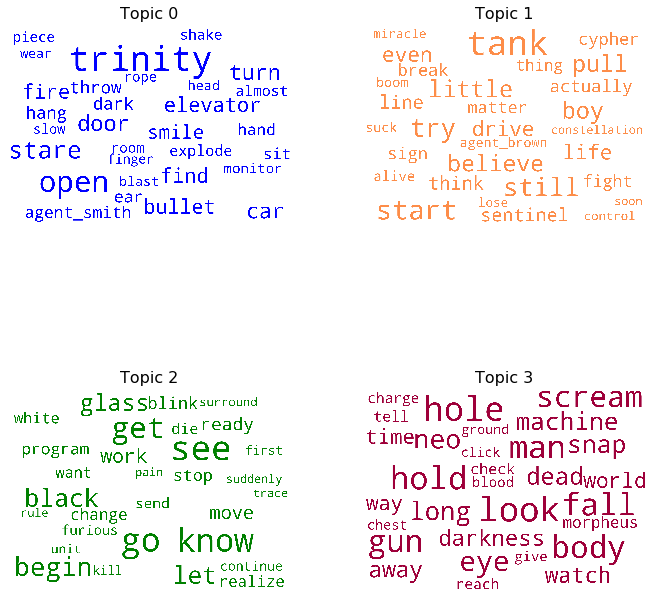

In [127]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

# cols = [color for name, color in mcolors.XKCD_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS - mcolors.TABLEAU_COLORS'

cols = ['blue','#fd8d49','green','#9e003a']
cloud = WordCloud(stopwords=stopwords_list,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=30,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False,num_words=30)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
#     print(i,topics[i][1])
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=-3, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.savefig('topic_wordcloud.png',dpi=180)
plt.show()